Max Group (0):
[(369, 120), (459, 142)]
[(478, 144), (595, 185)]
[(323, 109), (435, 132)]
[(500, 154), (607, 193)]
[(534, 279), (622, 132)]
[(543, 273), (623, 135)]
[(452, 346), (537, 397)]
[(137, 493), (265, 351)]
[(431, 340), (529, 403)]
[(151, 598), (210, 539)]
[(642, 248), (669, 164)]
[(402, 219), (497, 130)]
[(280, 170), (374, 102)]
[(158, 249), (225, 316)]
[(302, 108), (380, 123)]
[(457, 142), (512, 159)]
[(352, 199), (420, 142)]
[(143, 402), (228, 311)]
[(400, 217), (482, 140)]
[(140, 452), (191, 537)]
[(622, 199), (715, 244)]
[(353, 194), (433, 129)]
[(617, 322), (659, 213)]
[(700, 332), (714, 259)]
[(461, 243), (543, 149)]
[(282, 165), (362, 109)]
[(600, 187), (719, 242)]
[(700, 348), (718, 255)]
[(327, 560), (402, 468)]
[(163, 468), (246, 376)]
[(231, 151), (282, 115)]
[(554, 256), (619, 143)]
[(146, 471), (186, 535)]
[(208, 530), (323, 402)]
[(132, 500), (224, 395)]
[(343, 115), (394, 122)]
[(613, 321), (636, 262)]
[(787, 255), (789, 312)]
[(467, 243), (509, 192)]
[(252, 159

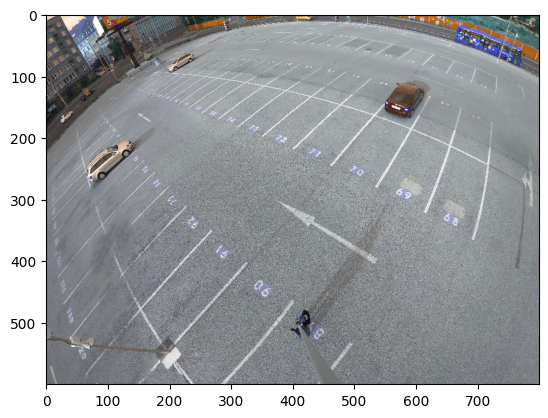

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

def group_lines(line_segments, epsilon, min_samples):
    # Convert line segments to feature vectors (start and end points)
    features = np.array([(x1, y1, x2, y2) for (x1, y1), (x2, y2) in line_segments])

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels = dbscan.fit_predict(features)

    # Create a dictionary to store the grouped line segments
    grouped_lines = {}

    # Iterate over each line segment and assign it to a group
    for idx, label in enumerate(labels):
        if label not in grouped_lines:
            grouped_lines[label] = []
        grouped_lines[label].append(line_segments[idx])

    return grouped_lines

img_path = os.path.join('GOPR6541.jpg')

img = cv2.imread(img_path)
img = cv2.resize(img, (int(img.shape[1] / 5), int(img.shape[0] / 5)))
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blur, threshold1=100, threshold2=200, apertureSize=3)

lines = cv2.HoughLinesP(canny, rho=1, theta=np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

desired_slope_range = (-10, 70)

line_segments = []  # List to store the line segments

for line_idx, line in enumerate(lines):
    x1, y1, x2, y2 = line[0]
    slope = (y2 - y1) / (x2 - x1 + 1e-5)  # Calculate slope (avoiding division by zero)
    if desired_slope_range[0] < slope < desired_slope_range[1] and x1 > 100 and y2 > 100:
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #cv2.putText(img, f"({x1}, {y1}), ({x2}, {y2})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        line_segments.append([(x1, y1), (x2, y2)])

# Group line segments using DBSCAN
epsilon = 10  # Maximum distance between points to be considered neighbors
min_samples = 2  # Minimum number of points in a cluster
grouped_lines = group_lines(line_segments, epsilon, min_samples)

main_lines = []
# Find the main lines based on specific criteria
for line in line_segments:
    # Criteria: Lines with lengths above a threshold are considered main lines
    x1, y1 = line[0]
    x2, y2 = line[1]
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    threshold = 100  # Adjust the threshold value as per your requirement
    if length > threshold:
        main_lines.append(line)

# Assign the main lines to a separate group
grouped_lines[len(grouped_lines)] = main_lines

# Find the group with the maximum number of lines
max_group_id = max(grouped_lines, key=lambda x: len(grouped_lines[x]))
max_group = grouped_lines[max_group_id]

# Draw rectangles between grouped lines
for i in range(len(max_group) - 1):
    line1 = max_group[i]
    line2 = max_group[i + 1]
    diff_x1 = abs(line2[0][0] - line1[0][0])
    diff_y1 = abs(line2[0][1] - line1[0][1])
    diff_x2 = abs(line2[1][0] - line1[1][0])
    diff_y2 = abs(line2[1][1] - line1[1][1])

    if 25 <= diff_x1 <= 100 and 25 <= diff_y1 <= 100 and 25 <= diff_x2 <= 100 and 25 <= diff_y2 <= 100:
        points = np.array([line1[0], line1[1], line2[1], line2[0]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)

# Fit rectangles to the grouped line segments
rectangles = []
parking_lot_counter = 1  # Initialize parking lot counter

for line in max_group:
    x1, y1 = line[0]
    x2, y2 = line[1]
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    center = ((x1 + x2) // 2, (y1 + y2) // 2)
    rectangles.append(cv2.minAreaRect(np.array([center, (x2, y2), (x1, y1)], dtype=np.int32)))

    # Draw text indicating the parking lot number
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    font_thickness = 1
    text_offset = 15
    cv2.putText(img, str(parking_lot_counter), (center[0], center[1] - text_offset), font, font_scale, (255, 0, 0), font_thickness)

    parking_lot_counter += 1  # Increment parking lot counter

# Draw rectangles on the image
for rect in rectangles:
    box = cv2.boxPoints(rect).astype(np.int32)
    cv2.polylines(img, [box], isClosed=True, color=(255, 0, 0), thickness=2)
    

# Draw polygons between the two blue lines
for i in range(len(max_group) - 1):
    line1 = max_group[i]
    line2 = max_group[i + 1]
    diff_x1 = abs(line2[0][0] - line1[0][0])
    diff_y1 = abs(line2[0][1] - line1[0][1])
    diff_x2 = abs(line2[1][0] - line1[1][0])
    diff_y2 = abs(line2[1][1] - line1[1][1])
    
    if 25 <= diff_x1 <= 100 and 25 <= diff_y1 <= 100 and 25 <= diff_x2 <= 100 and 25 <= diff_y2 <= 100:
        points = np.array([line1[0], line1[1], line2[1], line2[0]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.polylines(img, [points], isClosed=True, color=(0, 0, 255), thickness=2)
        
# Print the line coordinates of the group with the maximum number of lines
print(f"Max Group ({max_group_id + 1}):")
for line in max_group:
    print(line)

cv2.imshow('Image', canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
